<a href="https://colab.research.google.com/github/MaschinenNah/FramePred2021/blob/main/FramePred2021_01_moving_objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.utils import Sequence
from skimage import draw, morphology
import numpy as np
from matplotlib import pyplot as plt
import random

!git clone https://github.com/MaschinenNah/ml_utils
from ml_utils import load
from ml_utils import show
from ml_utils import frame_predict as fp

Cloning into 'ml_utils'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 124 (delta 57), reused 86 (delta 26), pack-reused 0
Receiving objects: 100% (124/124), 14.76 KiB | 7.38 MiB/s, done.
Resolving deltas: 100% (57/57), done.


Eine Funktion, die ein bewegtes Objekt in ein Numpy Array hineinschreibt



In [162]:
def write_moving_object_into(arr, seed):
  random.seed(seed)

  n_frames = arr.shape[0]
  frame_size = arr.shape[1]

  r = random.uniform(frame_size/10, frame_size/5)
  xpos = random.uniform(2*r, frame_size-2*r)
  ypos = random.uniform(2*r, frame_size-2*r)
  xspeed = random.uniform(-frame_size/10., frame_size/10.)
  yspeed = random.uniform(-frame_size/10., frame_size/10.)

  renderer = random.randint(0,1)

  for i in range(0, n_frames):
    xpos_new = xpos + xspeed
    if xpos_new < 0 or xpos_new > frame_size:
      xspeed *= -1
    else:
      xpos = xpos_new
    ypos_new = ypos + yspeed
    if ypos_new < 0 or ypos_new > frame_size:
      yspeed *= -1
    else:
      ypos = ypos_new

    if renderer == 0:
      for j in range(0, round(frame_size/20)):
        y, x = draw.circle_perimeter(round(xpos), round(ypos), round(r-j), shape=(frame_size, frame_size))
        arr[i, y, x] = 1
      
    else:
      for j in range(0, round(frame_size/20)):
        y, x = draw.rectangle_perimeter((round(xpos)-r+j, round(ypos)-r+j), extent=(2*r-2*j, 2*r-2*j), shape=(frame_size, frame_size))
        y = y.astype("uint8")
        x = x.astype("uint8")
        arr[i, y, x] = 1
      

    



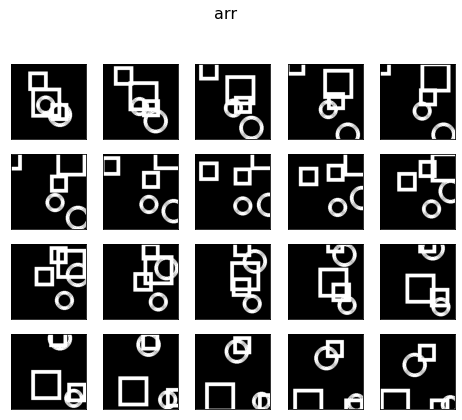

In [164]:
arr = np.zeros((20, 200, 200))

write_moving_object_into(arr, 1)
write_moving_object_into(arr, 2)
write_moving_object_into(arr, 3)
write_moving_object_into(arr, 4)
write_moving_object_into(arr, 5)

show.show_images_from_np_array(arr, "arr")